## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

Для того, чтобы начать исследование, необходимо установить необходимые библиотеки:

In [1]:
#установим библиотеки для исследования
import pandas as pd
from pymystem3 import Mystem
import matplotlib.pyplot as plt
from collections import Counter
#прочтем файл с исходным датасетом и запишем данные в df
df = pd.read_csv('/datasets/data.csv')
#для последующей лемматизации обозначим m
m = Mystem() 

Визуально изучим датасет:

In [2]:
#выведем первые 10 строк датасета
print(df.head(10))
#выведем основную информацию о качестве датасета
df.info()
#выведем информацию об основных значениях данных
df.describe()

   children  days_employed  dob_years education  education_id  \
0         1   -8437.673028         42    высшее             0   
1         1   -4024.803754         36   среднее             1   
2         0   -5623.422610         33   Среднее             1   
3         3   -4124.747207         32   среднее             1   
4         0  340266.072047         53   среднее             1   
5         0    -926.185831         27    высшее             0   
6         0   -2879.202052         43    высшее             0   
7         0    -152.779569         50   СРЕДНЕЕ             1   
8         2   -6929.865299         35    ВЫСШЕЕ             0   
9         0   -2188.756445         41   среднее             1   

      family_status  family_status_id gender income_type  debt   total_income  \
0   женат / замужем                 0      F   сотрудник     0  253875.639453   
1   женат / замужем                 0      F   сотрудник     0  112080.014102   
2   женат / замужем                 0    

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


### Вывод

При ознакомлении с датасетом были выявлены основные моменты, которые предстоит исправить для проведения дальнейшего анализа:
1. в столбце *children* отмечены выбросы по *min = -1* и *max = 20*;
2. в столбце *days_employed* присутствуют нехарактерные данным отрицательные значения, имеющие тип данных float64, а также есть пустые строки;
3. в столбце *education* текстовые данные имеют разный регистр;
4. в столбце *dob_years* присутсвуют нули;
5. в столбце *total_income* присутсвуют пустые строки;
6. в столбце *purpose* данные необходимо разбить на категории.

### Шаг 2. Предобработка данных

### Обработка пропусков

Проверим датасет на наличие пропусков:

In [3]:
#выведем сумму значений по всем пропускам
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Столбцы *days_employed* и *total_income* содержат пустые строки, которые возникли в результате неверного заполнения базы данных, либо же в форме ввода эти поля не являются обязательными, чем и пользуются клиенты, которые не хотят оставлять слишком много данных о себе.

Для корректной замены пустых строк необходимо очистить содержащиеся выбросы и категоризировать значения.

При осмотре датасета было замечено, что стаж представлен отрицательными значениями, скорей всего такая ошибка могла возникнуть на этапе ручного ввода данных - заемщики могли использовать *-*  как тире. 

Для корректного анализа переведем значения *days_employed* в абсолютные, так как стаж априори не может быть отрицательным. 

In [4]:
#приведение стажа в абсолютные значения
df['days_employed'] = df['days_employed'].abs()

Сгруппируем стаж относительно рабочего статуса клиента, выведем средние значения и медиану.

In [5]:
#сгруппируем значения стажа по рабочему статусу клиента и применим методы
df_grouped_income_type = df.groupby('income_type').agg({'days_employed':['count','mean', 'median']})
df_grouped_income_type

days_employed                              
                        count           mean         median
income_type                                                
безработный                 2  366413.652744  366413.652744
в декрете                   1    3296.759962    3296.759962
госслужащий              1312    3399.896902    2689.368353
компаньон                4577    2111.524398    1547.382223
пенсионер                3443  365003.491245  365213.306266
предприниматель             1     520.848083     520.848083
сотрудник               10014    2326.499216    1574.202821
студент                     1     578.751554     578.751554

Обнаружились аномальные средние значения стажа у двух категорий клиентов: *безработный* и *пенсионер*. Эти две группы ошибок предположительно возникли в результате неверной обозначенного формате ввода данных.

Предположим что данные записаны в днях, тогда приведем данные к годовым значениям и посмотрим еще раз на аномальные значения.

In [6]:
#создадим новую колонку 'years_employed' и обошатим датасет
df['years_employed'] = df['days_employed']/365
#сгруппируем значения стажа по рабочему статусу клиента и применим методы
df_grouped_income_type = df.groupby('income_type').agg({'years_employed':['count','mean', 'median']})
df_grouped_income_type

years_employed                          
                         count         mean       median
income_type                                             
безработный                  2  1003.873021  1003.873021
в декрете                    1     9.032219     9.032219
госслужащий               1312     9.314786     7.368132
компаньон                 4577     5.784998     4.239403
пенсионер                 3443  1000.009565  1000.584401
предприниматель              1     1.426981     1.426981
сотрудник                10014     6.373970     4.312884
студент                      1     1.585621     1.585621

Теперь четко видно, что присутсвуют аномально высокие значения стажа в категориях *безработный* и *пенсионер*. Конечно год за двадцать хороший подсчет, но все же это ошибки в вводе данных. Предположим, что для данных категорий клиентов ввод данных по стажу был осуществлен в часах. Проверим эту гипотезу:

In [7]:
#для запуска кода необходимо расскоментировать и перезапустить notebook
# def income_type_anomalies(df):
#     if df['income_type'] == 'безработный' or df['income_type'] == 'пенсионер':
#         return df['years_employed'] / 24
#     else:
#         return df['years_employed']
    
# df['years_employed'] = df.apply(income_type_anomalies, axis=1)
# df_grouped_income_type = df.groupby('income_type').agg({'years_employed':['count','mean']})
# df_grouped_income_type

Для пенсионеров средний стаж 41 год является нормальной величиной, в то время как для безработных спорной. 

In [8]:
#для запуска кода необходимо расскоментировать и перезапустить notebook
#print(df.loc[df['income_type'] == 'безработный'])

При более детальном рассмотрении клиентов со статусом безработный видно, что значение стажа превышает значение их возраста (38.5 > 31; 45.1 > 45), что говорит об ошибке в данных. Количество таких клиентов составляет менее сотой процента от общей выборки (а именно их двое) и присвоение им среднего значения не должно повлиять на качество данных.

In [9]:
#создадим функцию для расчета стажа пенсионеров - она переводит стаж пенсионера из дней в года
def income_type_retiree(df):
    if df['income_type'] == 'пенсионер':
        return df['years_employed'] / 24
    else:
        return df['years_employed']
#применим функцию для расчета стажа пенсионеров к значениям столбца 'years_employed'  
df['years_employed'] = df.apply(income_type_retiree, axis=1)

#создадим переменную для среднего значения столбца 'years_employed'
year_employed_avg = df['years_employed'].mean()
#создадим функцию для расчета стажа безработных - она заменяет стаж безработного на среднее значение
def income_type_unemployed(df):
    if df['income_type'] == 'безработный':
        return year_employed_avg
    else:
        return df['years_employed']
#применим функцию для расчета стажа безработных к значениям столбца 'years_employed'  
df['years_employed'] = df.apply(income_type_unemployed, axis=1)
#сгруппируем значения стажа по рабочему статусу клиента и применим методы
df_grouped_income_type = df.groupby('income_type').agg({'years_employed':['count','mean', 'median']})
df_grouped_income_type

years_employed                      
                         count       mean     median
income_type                                         
безработный                  2  12.816256  12.816256
в декрете                    1   9.032219   9.032219
госслужащий               1312   9.314786   7.368132
компаньон                 4577   5.784998   4.239403
пенсионер                 3443  41.667065  41.691017
предприниматель              1   1.426981   1.426981
сотрудник                10014   6.373970   4.312884
студент                      1   1.585621   1.585621

В предыдущих этапах мы создали столбец *years_employed* и привели данные в вид, пригодный для дальшейшего анализа. Соответсвенно необходимость в столбце *days_employed* отпала. Мы можем его удалить.

In [10]:
#удалим столбец с днями стажа
df = df.drop('days_employed', 1)

После обработки аномальных значений и приведения данных стажа в более однородный вид, проведем замену пустых строк. Для этого сначала просмотрим основные значения столбца *years_employed* для выбора замены - среднее или медиана:

In [11]:
df['years_employed'].describe()

count    19351.000000
mean        12.713827
std         14.670851
min          0.066141
25%          2.539751
50%          6.011563
75%         15.163371
max         50.380685
Name: years_employed, dtype: float64

Медиана значительно отличается от среднего значения, что говорит о смещении количества данных во вторую половину значений - проще говоря стажа более 7 лет значительно больше. Поэтому для замены остановим свой выбор на медиане:

In [12]:
#создадим переменную для медианы столбца 'years_employed'
year_employed_median = df['years_employed'].median()
#заменим пустые значения на значение медианы
df['years_employed'] = df['years_employed'].fillna(year_employed_avg)
#сгруппируем значения стажа по рабочему статусу клиента и применим методы
df_grouped_income_type = df.groupby('income_type').agg({'years_employed':['count','mean', 'median']})
df_grouped_income_type

years_employed                      
                         count       mean     median
income_type                                         
безработный                  2  12.816256  12.816256
в декрете                    1   9.032219   9.032219
госслужащий               1459   9.667573   8.329502
компаньон                 5085   6.487433   4.848039
пенсионер                 3856  38.576976  41.153615
предприниматель              2   7.121619   7.121619
сотрудник                11119   7.014201   4.963868
студент                      1   1.585621   1.585621

После замены пропусков в столбце *years_employed* снова посмотрим на количество пропусков:

In [13]:
#выведем сумму значений по всем пропускам
df.isna().sum()

children               0
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
years_employed         0
dtype: int64

Замена пустых строк в *years_employed* проведена успешно. Осталось заменить пустые строки в *total_income*. Для этого опять посмотрим на основные значения столбца и определимся с выбором значения для замены.

In [14]:
#посмотрим на основные значения столбца 'total_income'
df['total_income'].describe()

count    1.935100e+04
mean     1.674223e+05
std      1.029716e+05
min      2.066726e+04
25%      1.030532e+05
50%      1.450179e+05
75%      2.034351e+05
max      2.265604e+06
Name: total_income, dtype: float64

Выводятся очень непонятные значения. Попробуем вывести основные значения другим способом:

In [15]:
#посмотрим на основные значения столбца 'total_income'
print('min:', df['total_income'].min())
print('max:', df['total_income'].max())
print('mean:', df['total_income'].mean())
print('median:', df['total_income'].median())

min: 20667.26379327158
max: 2265604.028722744
mean: 167422.30220817294
median: 145017.93753253992


Среднее значение не сильно разнится с медианой - поэтому выбор замены не сильно должен отразиться на качестве значений. Заменим пустые строки столбца *total_income* на медиану:

In [16]:
#создадим переменную для медианы столбца 'total_income'
total_income_median = df['total_income'].median()
#проведем замену пустых строк на значение медианы
df['total_income'] = df['total_income'].fillna(total_income_median)

После замены пропусков в столбце *total_income* снова посмотрим на количество пропусков:

In [17]:
#выведем сумму значений по всем пропускам
df.isna().sum()

children            0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
years_employed      0
dtype: int64

Также при анализе датасета было выявлено, что столбец *children* имеет аномальные значения *-1* и *20*. Появилась гипотеза, что эти значения являются ошибками ручного ввода - минут был присвоен случайно, и также ноль был нажат по неосторожности. Посмотрим на уникальные значения этого столбца:

In [18]:
#выведем все уникальные значения
df['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

Мнжду значениями *5* и *20* отсутствуют промежуточные. Четко видно, что *-1* и *20* - ошибки. Избавимся от них, заменив *-1* на *1* и *20* на *2*.

In [19]:
#произведем значения по строкам, соответвующим условию
df.loc[(df['children'] == -1), 'children'] = 1
df.loc[(df['children'] == 20), 'children'] = 2

После замены снова проверим уникальные значения:

In [20]:
#выведем все уникальные значения
df['children'].unique()

array([1, 0, 3, 2, 4, 5])

Данные столбца *children* очищены от ошибок неверного ввода.

Далее проверим есть ли в столбце *dob_years* нулевые значения. Пришла я к этому в блоке категоризация, когда стала собирать значения возраста в группы, но это можно было заметить еще в самом начале при изучении минимального значения столбца *dob_years*, поэтому удаление нулевых значений помещен в этот этап.

In [21]:
#разделим знчения возраста клиентов на части, кототые могут соответсвовать общепринятым возрастным группам:
dublicated_age = pd.cut(df['dob_years'],
                             [0,14,18,35,64,df['dob_years'].max()])
#выведем количество значений каждой категории
dublicated_age.value_counts()

(35, 64]    13931
(18, 35]     6594
(64, 75]      899
(14, 18]        0
(0, 14]         0
Name: dob_years, dtype: int64

При пересчете оказалось, что сумма выведенных значений меньше на 101, соответсвенно не вошли нулевые значения. Проверим их наличие:

In [22]:
#выведем строки с нулевыми значениями возраста
display(df.loc[(df['dob_years'] == 0)])

       children  dob_years education  education_id          family_status  \
99            0          0   Среднее             1        женат / замужем   
149           0          0   среднее             1              в разводе   
270           3          0   среднее             1        женат / замужем   
578           0          0   среднее             1        женат / замужем   
1040          0          0    высшее             0              в разводе   
...         ...        ...       ...           ...                    ...   
19829         0          0   среднее             1        женат / замужем   
20462         0          0   среднее             1        женат / замужем   
20577         0          0   среднее             1  Не женат / не замужем   
21179         2          0    высшее             0        женат / замужем   
21313         0          0   среднее             1  Не женат / не замужем   

       family_status_id gender income_type  debt   total_income  \
99      

Все верно - количество нулевых значений равно 101. Нулевы значения как правило возникают, когда при вводе данных поле было пропущено, а система заменяет отсутсвие данных на машинопонятный в данном случае ноль. Произведем замену нулевых значений. Для этого посмотрим описание основных значений столбца *dob_years*, чтобы определить какое значение выбирать для замены - среднее или медиану: 

In [23]:
#посмотрим на основные значения столбца 'dob_years'
df['dob_years'].describe()

count    21525.000000
mean        43.293380
std         12.574584
min          0.000000
25%         33.000000
50%         42.000000
75%         53.000000
max         75.000000
Name: dob_years, dtype: float64

Среднее значение не критично отличается от медианы, поэтому в данном случае замена на любое из этих значений не исказит данные. Заменим нулевые значения на медиану:

In [24]:
#создадим переменную для медианы столбца 'dob_years'
dob_years_median = df['dob_years'].median()
#проведем замену нулевых значений на значение медианы
df.loc[(df['dob_years'] == 0), 'dob_years'] = dob_years_median

После замены еще раз посмотрим на основные значения:

In [25]:
#посмотрим на основные значения столбца 'dob_years'
df['dob_years'].describe()

count    21525.000000
mean        43.490453
std         12.218595
min         19.000000
25%         34.000000
50%         42.000000
75%         53.000000
max         75.000000
Name: dob_years, dtype: float64

Минимальное значение стало 19 лет, что соответсвует законодательно утвержденному возрасту для возможности предоставления кредита. Проверим замену еще раз наличие нулевых значений в столбце *dob_years*, чтобы убедиться в их отсутствии:

In [26]:
#выведем строки с нулевыми значениями возраста
print(df.loc[(df['dob_years'] == 0)])

Empty DataFrame
Columns: [children, dob_years, education, education_id, family_status, family_status_id, gender, income_type, debt, total_income, purpose, years_employed]
Index: []


Нулевые значения в стобце *dob_years* отсутвуют.

### Вывод

* В результате проверки датасета были обнаружены пустые строки в столбцах *days_employed* и *total_income*. Проведена обработка значений стажа в столбце *days_employed*, а именно категоризация в зависимости от типа занятости клиентов, очищение данных от выбросов (обнаружены аномально высокие значения по группам *безработные* и *пенсионеры*), создание нового столбца *years_employed* и замены пустых строк медианой.

* Проведена замена пустых строк в столбце *total_income* на медианное значение.

* Обнаружены нулевые значения в столбце *dob_years* и заменены на медианное значение.

В результате работы над этим этапом было предположено, что пропуски и нулевые значения как правило возникают на этапе ввода данных клиентом, так как возможно поля, в которых имелись такие отклонения, не являются обязательными для заполнения и клиенты имеют возможность их проигнорировать. По итогу проделанной работы пропуски и нулевые значения в датасете отсутсвуют, а также неверно введенные, в результате (предположительно) человеческого фактора, исправлены.

### Замена типа данных

Изначально, приступая к этому этапу возникла мысль произвести замену типа данных в столбцах *years_employed* и *total_income* с float64 на int64. 

В таком случае, как предпологалось, такая замена позволила бы нам в дальнейшем обрабатывать запросы быстрее и, если быть честными, целые числа легче воспринимаются в анализе.

In [27]:
#для запуска кода необходимо расскоментировать и перезапустить notebook
# df[['years_employed', 'total_income']] = df[['years_employed', 'total_income']].astype('int')

Однако хорошо поразмыслив о том, что трудовой стаж бывает и не целым годом, а общий доход содержит не всегда целые числа, то было принято решения округлить данные значения до одного знака после запятой:

In [28]:
#окрглим значения столбцов 'years_employed' и 'total_income'
df[['years_employed', 'total_income']] = df[['years_employed', 'total_income']].round(1)
#выведем первые 5 строк датасета
display(df.head())

   children  dob_years education  education_id     family_status  \
0         1       42.0    высшее             0   женат / замужем   
1         1       36.0   среднее             1   женат / замужем   
2         0       33.0   Среднее             1   женат / замужем   
3         3       32.0   среднее             1   женат / замужем   
4         0       53.0   среднее             1  гражданский брак   

   family_status_id gender income_type  debt  total_income  \
0                 0      F   сотрудник     0      253875.6   
1                 0      F   сотрудник     0      112080.0   
2                 0      M   сотрудник     0      145886.0   
3                 0      M   сотрудник     0      267628.6   
4                 1      F   пенсионер     0      158616.1   

                      purpose  years_employed  
0               покупка жилья            23.1  
1     приобретение автомобиля            11.0  
2               покупка жилья            15.4  
3  дополнительное образова

Значения столбцов *years_employed* и *total_income* округлены успешно.

Однако, требования есть требования, поэтому проведем замену типа данных в столбцах *years_employed* и *total_income* с float64 на int64. 

In [29]:
#проведем замену типа данных в столбцах 'years_employed' и 'total_income'
df[['years_employed', 'total_income']] = df[['years_employed', 'total_income']].astype('int64')
#выведем первые 5 строк датасета
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
dob_years           21525 non-null float64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null int64
purpose             21525 non-null object
years_employed      21525 non-null int64
dtypes: float64(1), int64(6), object(5)
memory usage: 2.0+ MB


Замена была проведена успешно.

Также на этом этапе было замечено, что в столбцах *education* и *family_status* значения находятся в разных регистрах. И среди значений столбца *gender* закралось нехарактерное полу значение.

In [30]:
#выведем уникальные значения столбца 'education'
df['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

In [31]:
#выведем уникальные значения столбца 'family_status'
df['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

In [32]:
#выведем уникальные значения столбца 'gender'
df['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

- В столбце *education* текст необходимо перевести в единый регистр, чтобы категории образования привелись в единый вид. 
- Также для визуального восприятия необходимо в единый регистр привести и столбец *family_status*. 
- В столбце *gender* обнаружилось неизвестное значение 'XNA' в количестве 1, которое не относится ни к одному полу. Скорей всего это ошибка ввода данных.

Переведем столбцы *education* и *family_status* в нижний регистр:

In [33]:
#приведем значения столбца 'education' в нижний регистр
df['education'] = df['education'].str.lower()
#выведем уникальные значения столбца 'education'
df['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

In [34]:
#приведем значения столбца 'education' в нижний регистр
df['family_status'] = df['family_status'].str.lower()
#выведем уникальные значения столбца 'family_status'
df['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'не женат / не замужем'], dtype=object)

Значения успешно приведены к одному регистру, что упрощает анализ и дальнейшее восприятие данных.

Далее устраним неизвестное значение *XNA* в столбце *gender*. Для этого определим самое популярное значение - моду:

In [35]:
#посмотрим на основные значения столбца 'dob_years'
df['gender'].describe()

count     21525
unique        3
top           F
freq      14236
Name: gender, dtype: object

Модой является *F*. Соответсвенно отнесем значение 'XNA' в столбце *gender* к женскому полу.

In [36]:
#произведем замену 'XNA' на 'F'
df.loc[(df['gender'] == 'XNA'), 'gender'] = 'F'
#выведем уникальные значения столбца 'gender'
df['gender'].unique()

array(['F', 'M'], dtype=object)

### Вывод

* Для улучшения визуального восприятия и сохранения качества данных было принято решение округленить значения в столбцах *years_employed* и *total_income*.
* Ткаже значения в столбце *education* и *family_status* были приведены в единый регистр для дальнейшей читабельности.
* В столбце *gender* обнаружилось неизвестное значение 'XNA' которое было устранено с помощью присоединения к моде столбца *F*.

### Обработка дубликатов

Проверим датасет на наличие дубликатов. 

In [37]:
#выведем все дубликаты 
print ('Дубликатов в таблице:', df.duplicated().sum())

Дубликатов в таблице: 72


При проверке датасета было выявлено 72 дубликата . Попробуем произвести их удаление и посмотреть на результат:

In [38]:
#удалим все дубликаты
df = df.drop_duplicates()
df.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,years_employed
0,1,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,23
1,1,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,11
2,0,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145886,покупка жилья,15
3,3,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,11
4,0,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,38
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,43.0,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,12
21521,0,67.0,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,39
21522,1,38.0,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,5
21523,3,38.0,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,8


Количество строк сократилось на 72. Соответственно внутри датасета находилось 72 дубликата.

### Вывод

На данном этапе были удалены дубликаты. Количество строк сократилось на 73 значений - с 21525 до 21453.

### Лемматизация

В столбце *purpose* находятся цели получения кредита, которые оставили сами клиенты. Цели имеют разный тип написания в зависимости от количества слов и их форм, их нужно разбить на определенные группы. Для этого необходимо применить лемматизацию и категоризировать цели кредита:

In [39]:
#лемматизируем 'purpose' и запишем его в новый столбец 'purpose_lemmas'
df['purpose_lemmas'] = df['purpose'].apply(lambda x: m.lemmatize(x))
#посмотрим на датасет
df.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,years_employed,purpose_lemmas
0,1,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,23,"[покупка, , жилье, \n]"
1,1,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,11,"[приобретение, , автомобиль, \n]"
2,0,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145886,покупка жилья,15,"[покупка, , жилье, \n]"
3,3,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,11,"[дополнительный, , образование, \n]"
4,0,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,38,"[сыграть, , свадьба, \n]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,43.0,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,12,"[операция, , с, , жилье, \n]"
21521,0,67.0,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,39,"[сделка, , с, , автомобиль, \n]"
21522,1,38.0,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,5,"[недвижимость, \n]"
21523,3,38.0,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,8,"[на, , покупка, , свой, , автомобиль, \n]"


После визуального анализа стоит подробнее изучить встречаемость слов, для этого произведем выделение ключевых слов с помощью лемматизации и посчитаем их частотность.

In [40]:
#переведем колонку в список и превратим его в строку
keywords = ' '.join(df['purpose'].to_list())
#применим лемматизацию к полученным ключевым словам
lemmas = m.lemmatize(keywords)
#посчитаем частотность ключевых слов
print(Counter(lemmas))

Counter({' ': 55020, 'недвижимость': 6351, 'покупка': 5897, 'жилье': 4460, 'автомобиль': 4306, 'образование': 4013, 'с': 2918, 'операция': 2604, 'свадьба': 2323, 'свой': 2230, 'на': 2221, 'строительство': 1878, 'высокий': 1374, 'получение': 1314, 'коммерческий': 1311, 'для': 1289, 'жилой': 1230, 'сделка': 941, 'дополнительный': 906, 'заниматься': 904, 'подержать': 853, 'проведение': 767, 'сыграть': 765, 'сдача': 651, 'семья': 638, 'собственный': 635, 'со': 627, 'ремонт': 607, 'приобретение': 461, 'профильный': 436, 'подержанный': 111, '\n': 1})


Изучив данные в новом столбце *purpose_lemmas* и частотности ключевых слов, выделены ключевые категории целей кредита. Логика разбивки на категории: по словам *свадьба*, *образование* и *автомобиль* категории строятся в прямой зависимости, по *недвижимость* и *жилье* необходимо выделить единую категорию.

In [41]:
#создадим функцию, которая в зависимости от ключевого слова будет присваивать категории. 
def generate_purpose_type(data):
    if 'свадьба' in data:
        return 'проведение свадьбы'   
    elif 'недвижимость' in data:
        return 'операции с недвижимостью'
    elif 'жилье' in data:
        return 'операции с недвижимостью'
    elif 'образование' in data:
        return 'получение образования'
    elif 'автомобиль' in data:
        return 'приобретение автомобиля'
    else:
        return 'неизвестная категория'
#применим функцию generate_purpose_type и результаты запишем в новый столбец 'purpose_type'
df['purpose_type'] = df['purpose_lemmas'].apply(lambda x: generate_purpose_type(x))
#посмотрим на датасет
df.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,years_employed,purpose_lemmas,purpose_type
0,1,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,23,"[покупка, , жилье, \n]",операции с недвижимостью
1,1,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,11,"[приобретение, , автомобиль, \n]",приобретение автомобиля
2,0,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145886,покупка жилья,15,"[покупка, , жилье, \n]",операции с недвижимостью
3,3,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,11,"[дополнительный, , образование, \n]",получение образования
4,0,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,38,"[сыграть, , свадьба, \n]",проведение свадьбы
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,43.0,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,12,"[операция, , с, , жилье, \n]",операции с недвижимостью
21521,0,67.0,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,39,"[сделка, , с, , автомобиль, \n]",приобретение автомобиля
21522,1,38.0,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,5,"[недвижимость, \n]",операции с недвижимостью
21523,3,38.0,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,8,"[на, , покупка, , свой, , автомобиль, \n]",приобретение автомобиля


Проверим столбец *purpose_type* на количество пропусков или пустых строк:


In [42]:
#проверим данные на значения 'None'
print(df.loc[df['purpose_type'] == 'None'])

Empty DataFrame
Columns: [children, dob_years, education, education_id, family_status, family_status_id, gender, income_type, debt, total_income, purpose, years_employed, purpose_lemmas, purpose_type]
Index: []


In [43]:
#проверим данные на пропуски
df['purpose_type'].isna().sum()

0

Всем значениям цели присвоены категории. Пропуски и пустые строки отсутвуют.

Соответсвенно для дальнейшего анализа потребность в столбцах *purpose* и *purpose_lemmas* отсутвует. Можем их удалить:

In [44]:
#удалим столбец 'purpose' и 'purpose_lemmas'
df = df.drop(['purpose', 'purpose_lemmas'], 1)
#выведем датасет
display(df.head())

   children  dob_years education  education_id     family_status  \
0         1       42.0    высшее             0   женат / замужем   
1         1       36.0   среднее             1   женат / замужем   
2         0       33.0   среднее             1   женат / замужем   
3         3       32.0   среднее             1   женат / замужем   
4         0       53.0   среднее             1  гражданский брак   

   family_status_id gender income_type  debt  total_income  years_employed  \
0                 0      F   сотрудник     0        253875              23   
1                 0      F   сотрудник     0        112080              11   
2                 0      M   сотрудник     0        145886              15   
3                 0      M   сотрудник     0        267628              11   
4                 1      F   пенсионер     0        158616              38   

               purpose_type  
0  операции с недвижимостью  
1   приобретение автомобиля  
2  операции с недвижимостью  
3 

Проведем подсчет количества значений по категориям цели:

In [45]:
#выведем количество значений относительно категорий
df['purpose_type'].value_counts()

операции с недвижимостью    10811
приобретение автомобиля      4306
получение образования        4013
проведение свадьбы           2323
Name: purpose_type, dtype: int64

Отчетливо видно, что модой в данной выборке являются операции с недвижимостью. Они соствляют более половины всех целей получения кредита.

### Вывод

В результате применения лемматизации к столбцу *purpose* удалось выявить ключевые слова, определить логику разделения на категории в зависимости от ключевых слов и найти точные количества по каждой отдельной категории.

### Категоризация данных

На предыдущих этапа мы коснулись категоризации данных, а именно, разбили на категории цели предоставления кредита. Для дальнейшего анализа необходимо произвести категоризацию данных по столбцам *children* ('нет детей', 'есть дети', 'многодетные') и *dob_years* ('молодые', 'взрослые', 'пожилые'), а также разделим доход в столбце *total_income* на пять равных категорий ('стандартный', 'ниже среднего', 'средний', 'выше среднего', 'высокий').

Начнем категоризацию по количеству детей. 

In [46]:
#создадим функцию, которая будет присваивать категории в зависимости от количества детей:
def children_group(children):
    if children == 0:
        return 'нет детей'
    elif children < 3:
        return 'есть дети'
    return 'многодетные' 
#применим функцию к значениям столбца 'children' и созраним в новом столбце 'children_group'
df['children_group'] = df['children'].apply(children_group)
#посмотрим на датасет
df.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,years_employed,purpose_type,children_group
0,1,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875,23,операции с недвижимостью,есть дети
1,1,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080,11,приобретение автомобиля,есть дети
2,0,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145886,15,операции с недвижимостью,нет детей
3,3,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628,11,получение образования,многодетные
4,0,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616,38,проведение свадьбы,нет детей


Значения присвоились успешно. Посчитаем количество значений по категориям.

In [47]:
#посчитаем количество значений в зависимости от категорий 
df['children_group'].value_counts()

нет детей      14090
есть дети       6983
многодетные      380
Name: children_group, dtype: int64

Из данных видно, что почти две трети заемщиков не имеют детей.

Далее проведем категоризацию по возрастным группам.

In [48]:
#создадим функцию, которая будет присваивать категории в зависимости возраста заемщика:
def dob_years_group(dob_years):
    if dob_years < 35:
        return 'молодые'
    elif dob_years <= 60:
        return 'взрослые'
    return 'пожилые' 
#применим функцию к значениям столбца 'dob_years' и созраним в новом столбце 'children_group'
df['dob_years_group'] = df['dob_years'].apply(dob_years_group)
#посмотрим на датасет
df.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,years_employed,purpose_type,children_group,dob_years_group
0,1,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875,23,операции с недвижимостью,есть дети,взрослые
1,1,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080,11,приобретение автомобиля,есть дети,взрослые
2,0,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145886,15,операции с недвижимостью,нет детей,молодые
3,3,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628,11,получение образования,многодетные,молодые
4,0,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616,38,проведение свадьбы,нет детей,взрослые


Значения присвоились успешно. Посчитаем количество значений по категориям.

In [49]:
#посчитаем количество значений в зависимости от категорий 
df['dob_years_group'].value_counts()

взрослые    13360
молодые      5967
пожилые      2126
Name: dob_years_group, dtype: int64

По результатам анализа видно, что большая часть заемщиков это лица в возрасте от 35 до 60 лет.

Категоризируем доход на пять равных категорий ('стандартный', 'ниже среднего', 'средний', 'выше среднего', 'высокий').

Применим метод cut():

In [50]:
#разделим доход по уровням и запишем полученные значения в новый столбец с присвоением названия каждой категории
df['df_grouped_total_income'] = pd.cut(df['total_income'], 5, labels=['стандартный', 'ниже среднего', 'средний', 'выше среднего', 'высокий'])
#посмотрим на датасет
df.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,years_employed,purpose_type,children_group,dob_years_group,df_grouped_total_income
0,1,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875,23,операции с недвижимостью,есть дети,взрослые,стандартный
1,1,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080,11,приобретение автомобиля,есть дети,взрослые,стандартный
2,0,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145886,15,операции с недвижимостью,нет детей,молодые,стандартный
3,3,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628,11,получение образования,многодетные,молодые,стандартный
4,0,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616,38,проведение свадьбы,нет детей,взрослые,стандартный


Посчитаем в количественном выражении каждую категорию и посмотрим средние значения и медианы каждой группы:

In [51]:
#выведем значения дохода в зависимости от группы дохода
df_grouped_total_income = df.groupby('df_grouped_total_income').agg({'total_income':['count','mean', 'median']})
df_grouped_total_income

total_income                       
                               count          mean   median
df_grouped_total_income                                    
стандартный                    21167  1.586681e+05   145017
ниже среднего                    257  5.788216e+05   546619
средний                           21  1.101236e+06  1091627
выше среднего                      6  1.621550e+06  1654461
высокий                            2  2.233228e+06  2233228

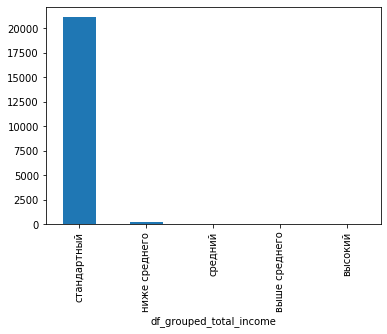

In [52]:
df.groupby('df_grouped_total_income')['total_income'].count().plot(kind='bar')

Отчетливо видно, что основное количество значений дохода находится в стандартной группе. Такое неравномерное распределиение количества сильно влияет на достоверность данных в остальных группах. На основании этого было принято решение воспользоваться qcut():

In [53]:
#разделим доход по уровням и запишем полученные значения в новый столбец с присвоением названия каждой категории
df['df_grouped_total_income'] = pd.qcut(df['total_income'], 5, labels=['стандартный', 'ниже среднего', 'средний', 'выше среднего', 'высокий'])
#посмотрим на датасет
df.head()

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,years_employed,purpose_type,children_group,dob_years_group,df_grouped_total_income
0,1,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875,23,операции с недвижимостью,есть дети,взрослые,высокий
1,1,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080,11,приобретение автомобиля,есть дети,взрослые,ниже среднего
2,0,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145886,15,операции с недвижимостью,нет детей,молодые,средний
3,3,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628,11,получение образования,многодетные,молодые,высокий
4,0,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616,38,проведение свадьбы,нет детей,взрослые,выше среднего


Посчитаем в количественном выражении каждую категорию и посмотрим средние значения и медианы каждой группы:

In [54]:
#выведем значения дохода в зависимости от группы дохода
df_grouped_total_income = df.groupby('df_grouped_total_income').agg({'total_income':['count','mean', 'median']})
df_grouped_total_income

total_income                       
                               count           mean  median
df_grouped_total_income                                    
стандартный                     4291   75425.800280   78716
ниже среднего                   4290  116719.968298  116007
средний                         4291  145240.684456  145017
выше среднего                   4290  181666.112121  179798
высокий                         4291  307072.903053  269801

Теперь видно, что категории по количеству значений однородны, соответсвенно здесь нам можно ориентироваться на количественные значения каждой группы.

### Вывод

На данном этапе были категоризированы столбцы *children* по количеству детей и *dob_years* по возрастным группам. На основании проведенного анализа было выявлено, что две трети заемщиков не имеют детей, а также больше половины всех заемщиков находятся в категории *взрослые* (от 35 до 60 лет). Также проведена категоризация дохода на пять групп.

### Шаг 3. Ответьте на вопросы

Предварительно посмотрим на распределение значений просрочек и возвратов:

In [56]:
df['debt'].value_counts()

0    19712
1     1741
Name: debt, dtype: int64

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Проведем анализ зависимости путем построения сводной таблицы и графика.

In [57]:
#сгруппируем количество просрочек по группе наличия детей и применим методы
df_grouped_children_debt = df.groupby('children_group').agg({'debt':['count','mean']})
df_grouped_children_debt

debt          
                count      mean
children_group                 
есть дети        6983  0.092654
многодетные       380  0.081579
нет детей       14090  0.075444

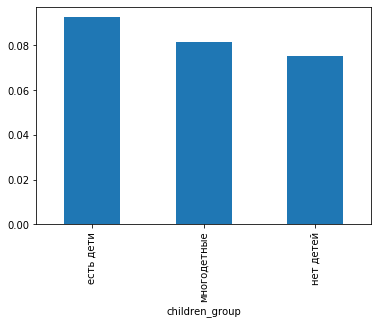

In [58]:
#построим график
df.groupby('children_group')['debt'].mean().plot(kind='bar')

### Вывод

В ходе анализа зависимости между наличием детей и возвратом кредита в срок было выявлено, что наименьшее число просрочек допускают заемщики у которых нет детей. Предположительно данная зависимость может быть обусловлена наличием бытовых расходов и дополнительных забот, связанных с наличием детей. В следсвие чего, заемщики, имеющие детей могут забывать о наличии кредита или может возникать нехватка денежных средств на его погашение.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

Проведем анализ зависимости путем построения сводной таблицы и графика.

In [59]:
#сгруппируем количество просрочек по группе семейного статуса и применим методы
df_grouped_family_status_debt = df.groupby('family_status').agg({'debt':['count','mean']})
df_grouped_family_status_debt

debt          
                       count      mean
family_status                         
в разводе               1195  0.071130
вдовец / вдова           959  0.065693
гражданский брак        4150  0.093494
женат / замужем        12339  0.075452
не женат / не замужем   2810  0.097509

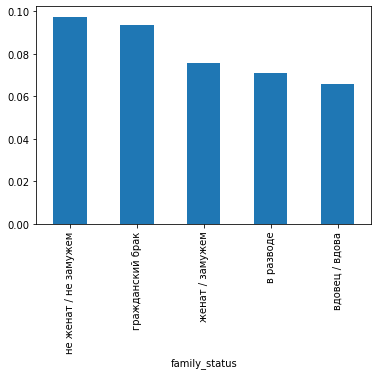

In [60]:
#построим график
df.groupby('family_status')['debt'].mean().sort_values(ascending=False).plot(kind='bar')

### Вывод

В ходе анализа зависимости между семейным положением и возвратом кредита в срок было выявлено, что с процессом жизни и сменой семейных статусов ответсвенность заемщиков повышается. Если расмотреть типичные паттерны поведения людей, находящихся в разных социальных ролях относительно брака, то можно отметить, что самыми "безответсвенными" являются как правило одинокие ничем не обязанные кому-либо люди. Не удивительно, что данная теория находит свое отражение и в нашем исследовании. Соответственно, в глазах займодателя наименнее рискованными группами будут являются, которые содержат в себе людей, принявших на себя определенные обязанности и ответсвенность перед другими людьми на официального "договора"(к чему относится и брак), что и подтверждают данные нашего анализа. 

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

В ходе анализа двух предыдущих этапов и выявления зависимостей было отмечено, что механика действий для построения сводной таблицы и графика идентична. На основании этого было принято решение создать функцию для повторения этих действий:

In [61]:
#создадим функцию для генерации таблицы и графика при формировании вывода
def generate_report(df, group, chart_type):
    df_grouped_purpose_debt = df.groupby(group).agg({'debt':['count','mean']})
    print(df_grouped_purpose_debt)
    df.groupby(group)['debt'].mean().sort_values(ascending=False).plot(kind=chart_type)

Применим функцию для выявления зависимости:

                         debt          
                        count      mean
df_grouped_total_income                
стандартный              4291  0.080168
ниже среднего            4290  0.082751
средний                  4291  0.086693
выше среднего            4290  0.086247
высокий                  4291  0.069914


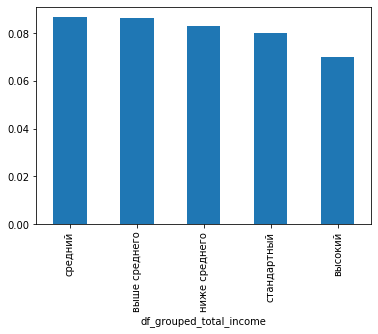

In [62]:
#передадим функции в качестве параметров столбец для зависимости и вид графика
generate_report(df, 'df_grouped_total_income', 'bar')

С помощью функции мы получили необходимую сводную таблицу и график.

### Вывод

Изучив результаты анализа зависимости между уровнем дохода и возвратом кредита в срок можно отметить, что наибольшую просрочку допускают заемщики со средним и выше среднего уровнями дохода, что обусловлено психологическими особенностями поведения людей при обращении с денежными ресурсами. Средний и выше среднего уровни дохода позволяют людям рассчитывать на большее количество материальных благ, но не настолько, чтобы не заботится о денежных ресурсах, за счет которых они прибретены. Соответсвенно, доходы заемщика ниже среднего и стандартный обеспечивают займодателя увернностью о снижении риска просрочки, так как таким клиентам всеже приходится следить за расходованием своих ресурсов. Наименее рискованной по результатам анализа оказалась группой с клиентами, имеющими высокий доход, так как эти люди имеют достаточно денежных ресурсов и источников доходов, чтобы покрывать свои обязательства.


- Как разные цели кредита влияют на его возврат в срок?

Проведем анализ зависимости путем построения сводной таблицы и графика с помощью функции.

                           debt          
                          count      mean
purpose_type                             
операции с недвижимостью  10811  0.072334
получение образования      4013  0.092200
приобретение автомобиля    4306  0.093590
проведение свадьбы         2323  0.080069


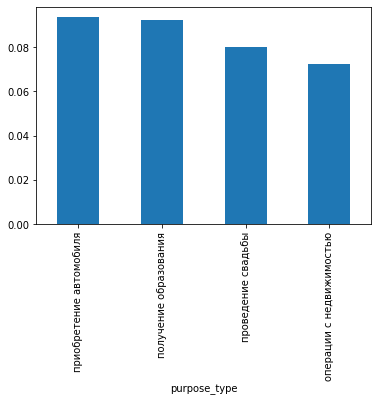

In [63]:
#передадим функции в качестве параметров столбец для зависимости и вид графика
generate_report(df, 'purpose_type', 'bar')

### Вывод

В ходе анализа зависимости между целью кредита и возвратом кредита в срок было выявлено, что наименее рисковым явлеются цели связанные с операциями с недвижимостью, при как мы помним наибольшем количестве выданных займов под эту цель. Предположительно заемщики, взявшие кредит под операции с недвижимостью не несут существенных расходов по содержанию данного типа имущества, а также имущество такого типа имеют более высокую ценность с психолошической точки зрения. Никто не хочет лишиться жилья или недвижимости для бизнеса из-за невозможночти уплаты кредита. Отмечено, что чаще всего просрочки допускают при приобретении автомобиля, что может быть связано с наличием дополнительных расходов, которые ложатся на плечи автовладельца при появлении автомобиля, и которые заемщики не учитывают при взятии кредита.

### Шаг 4. Общий вывод

В ходе анализа зависимостей между определенным фактором и возвратом кредита в срок были выявлены следующие наблюдения:
* наименьшее число просрочек допускают заемщики у которых нет детей (предположительно данная зависимость может быть обусловлена наличием бытовых расходов и дополнительных забот, связанных с наличием детей);
* с процессом смены семейных статусов ответсвенность заемщиков повышается, больше всего просрочек допускают заемщики не состоящие в официальном браке (в нашем исследовании нашла отражение теория паттернов социального поведения людей, находящихся в разных ролях относительно бракая. Можно отметить, что самыми "безответсвенными" являются как правило одинокие и ничем не обязанные кому-либо люди. Не удивительно, что данная теория находит свое отражение и в нашем исследовании);
* наибольшую просрочку допускают заемщики со средним и выше среднего уровнями дохода, что обусловлено психологическими особенностями поведения людей при обращении с денежными ресурсами. Соответсвенно, доходы заемщика ниже среднего и стандартный обеспечивают займодателя увернностью о снижении риска просрочки. Наименее рискованной по результатам анализа оказалась группой с клиентами, имеющими высокий доход;
* наименее рисковым являются цели связанные с операциями с недвижимостью. Чаще всего просрочки допускают при приобретении автомобиля, что может быть связано с наличием дополнительных расходов, которые ложатся на плечи автовладельца при появлении автомобиля, и которые заемщики не учитывают при взятии кредита.